🔧 **Setup Required**: Before running this notebook, please follow the [setup instructions](../README.md#setup-instructions) to configure your environment and API keys.

# LangGraph Multi-Agent Yelp Navigator

An educational example of building a multi-agent system using LangGraph to create an intelligent Yelp business search assistant.

## What You'll Learn

- How to orchestrate multiple specialized nodes working together
- How to implement conditional routing based on user needs
- How to integrate external tools and APIs into LangGraph workflows
- How to add quality control through a supervisor pattern

## Architecture

The system has **6 specialized nodes**:

1. **Clarification Node** - Extracts query, location, and detail level from user input
2. **Search Node** - Finds businesses matching the criteria
3. **Details Node** - Fetches additional info (websites, descriptions) - *optional*
4. **Sentiment Node** - Analyzes customer reviews - *optional*
5. **Summary Node** - Creates a user-friendly response
6. **Supervisor Approval Node** - Reviews quality and can request revisions

**Workflow:** User Query → Clarification → Search → [Details] → [Sentiment] → Summary → Approval → End

Nodes in brackets are only called when the user needs that level of detail.

## Prerequisites

**Start Hayhooks server:**
```bash
cd yelp-navigator
uv run sh build_all_pipelines.sh && sh start_hayhooks.sh
```

To run the agent, use GPT-OSS 

```
ollama pull gpt-oss:20b-latest
```

In [1]:
# =============================================================================
# STEP 1: Imports and Configuration
# =============================================================================

import os
import json
import requests
from typing import Annotated, TypedDict, List, Dict, Any
from operator import add

# LangGraph for building agent workflows
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.agents import create_agent
from dotenv import load_dotenv
from pathlib import Path
from langchain_ollama import ChatOllama



# Load .env from the root of ch8 directory
root_dir = Path(__file__).parent.parent if "__file__" in globals() else Path.cwd().parent
load_dotenv(root_dir / ".env")

# Import custom agent logic from helper modules
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'langgraph-helpers'))
from langgraph_helpers.nodes import clarification_node, supervisor_approval_node
from langgraph_helpers.nodes import search_node, details_node, sentiment_node, summary_node
from langgraph_helpers.tools import search_businesses, get_business_details, analyze_reviews_sentiment, set_base_url

# Configure endpoints
BASE_URL = "http://localhost:1416"  # Hayhooks server
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

set_base_url(BASE_URL)

if not OPENAI_API_KEY:
    print("⚠️  Warning: OPENAI_API_KEY not set. Please add it to your .env file.")
else:
    print("✅ OpenAI API key configured")
    print(f"✅ Hayhooks server: {BASE_URL}")

✅ OpenAI API key configured
✅ Hayhooks server: http://localhost:1416


In [ ]:
# =============================================================================
# STEP 2: Define Agent State
# =============================================================================
# AgentState is the "shared memory" for all nodes in the workflow.
# Each node reads from and writes to this state as the workflow progresses.

class AgentState(TypedDict):
    """State shared across all nodes in the workflow."""
    
    # Conversation tracking
    messages: Annotated[List[BaseMessage], add]  # Full conversation history
    
    # User intent (set by Clarification Node)
    user_query: str              # Original user question
    clarified_query: str         # What they're looking for (e.g., "Mexican restaurants")
    clarified_location: str      # Where to search (e.g., "Austin, Texas")
    detail_level: str            # "general", "detailed", or "reviews"
    
    # Workflow control
    clarification_complete: bool  # True when ready to proceed to search
    next_agent: str              # Which node to call next (enables conditional routing)
    
    # Node results
    agent_outputs: Dict[str, Any]  # Results from each node (search, details, sentiment)
    
    # Final output
    final_summary: str  # User-friendly response
    
    # Quality control (for Supervisor Approval Node)
    approval_attempts: int      # How many times supervisor has reviewed (max 2)
    needs_revision: bool        # True if summary needs improvement
    revision_feedback: str      # What to improve

## Step 3: Initialize Language Model

In [3]:
# Initialize the LLM that will power our agents
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# NOTE: A LOCAL MODEL WILL BE MUCH SLOWER THAN OPENAI'S API
# llm = ChatOllama(
#                 model="gpt-oss:20b",
#                 temperature=0,
#                 timeout=60,
#             )

In [ ]:
# =============================================================================
# STEP 4: Create Node Wrapper Functions
# =============================================================================
# Wrappers pass the LLM to nodes that need it for reasoning

def clarification_agent_wrapper(state: AgentState) -> AgentState:
    """Extracts query, location, and detail level from user input."""
    return clarification_node(state, llm)

def supervisor_approval_agent_wrapper(state: AgentState) -> AgentState:
    """Reviews summary quality and decides if revision is needed."""
    return supervisor_approval_node(state, llm)

In [ ]:
# Wrappers pass tools to nodes that interact with external pipelines

def search_agent_wrapper(state: AgentState) -> AgentState:
    """Searches for businesses using the Hayhooks search pipeline."""
    return search_node(state, search_businesses)

def details_agent_wrapper(state: AgentState) -> AgentState:
    """Fetches business details (website, description) via Hayhooks."""
    return details_node(state, get_business_details)

def sentiment_agent_wrapper(state: AgentState) -> AgentState:
    """Analyzes review sentiment via Hayhooks sentiment pipeline."""
    return sentiment_node(state, analyze_reviews_sentiment)

def summary_agent_wrapper(state: AgentState) -> AgentState:
    """Synthesizes all information into a user-friendly response."""
    return summary_node(state, llm)

In [ ]:
# =============================================================================
# STEP 5: Define Routing Logic and Build the Workflow
# =============================================================================

def route_after_clarification(state: AgentState) -> str:
    """Route to search if clarification is complete, otherwise continue clarifying."""
    if state.get("clarification_complete", False):
        return "search"
    return "clarification"


def route_after_search(state: AgentState) -> str:
    """Route based on detail level: general->summary, detailed/reviews->details."""
    detail_level = state.get("detail_level", "general")
    
    if detail_level == "general":
        return "summary"
    else:  # detailed or reviews - both need details first
        return "details"


def route_after_details(state: AgentState) -> str:
    """Route from details node based on detail level."""
    detail_level = state.get("detail_level", "general")
    
    if detail_level == "reviews":
        return "sentiment"
    else:
        return "summary"


def route_from_supervisor_approval(state: AgentState) -> str:
    """Route from supervisor approval to either END or back to a node."""
    next_agent = state.get("next_agent", "end")
    
    if next_agent == "end":
        return END
    
    # Supervisor wants to rerun a node
    return next_agent

def build_workflow_graph() -> StateGraph[AgentState]:
    """Builds a true pipeline architecture for Yelp Navigator.
    
    Pipeline Flow:
    1. Clarify → Search (sequential, clarify may loop)
    2. Search → Sentiment OR Details OR Summary (based on detail_level)
    3. Details → Sentiment OR Summary (based on detail_level)
    4. Sentiment → Summary (always)
    5. Summary → Approval (always)
    6. Approval → END or back to any step for revision
    """
    # Build the graph
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("clarification", clarification_agent_wrapper)
    workflow.add_node("search", search_agent_wrapper)
    workflow.add_node("details", details_agent_wrapper)
    workflow.add_node("sentiment", sentiment_agent_wrapper)
    workflow.add_node("summary", summary_agent_wrapper)
    workflow.add_node("supervisor_approval", supervisor_approval_agent_wrapper)
    
    # Add edges - TRUE PIPELINE ARCHITECTURE
    # START -> Clarification (may loop back to itself)
    workflow.add_edge(START, "clarification")

    # Clarification loops or moves to search
    workflow.add_conditional_edges(
        "clarification",
        route_after_clarification,
        {"clarification": "clarification", "search": "search"}
    )

    # Search -> Details OR Summary (based on detail level)
    workflow.add_conditional_edges(
        "search",
        route_after_search,
        {"details": "details", "summary": "summary"}
    )

    # Details -> Sentiment OR Summary (based on detail level)
    workflow.add_conditional_edges(
        "details",
        route_after_details,
        {"sentiment": "sentiment", "summary": "summary"}
    )

    # Sentiment -> Summary (always)
    workflow.add_edge("sentiment", "summary")

    # Summary -> Supervisor Approval (always)
    workflow.add_edge("summary", "supervisor_approval")

    # Supervisor Approval can route back to nodes or to END
    workflow.add_conditional_edges(
        "supervisor_approval",
        route_from_supervisor_approval,
        {
            "search": "search",
            "details": "details", 
            "sentiment": "sentiment",
            "summary": "summary",
            END: END
        }
    )
    return workflow

# Compile the graph with increased recursion limit for approval loops
graph = build_workflow_graph().compile()

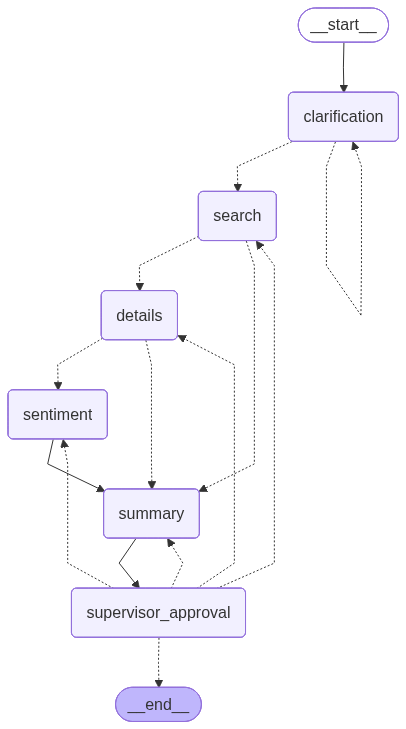

In [8]:
# Visualize the workflow graph
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(graph.get_graph())

## Examples: Running the Multi-Agent System

Below are three examples showing different detail levels:
- **General**: Basic business info only
- **Detailed**: Includes websites and descriptions
- **Reviews**: Full analysis with sentiment

### Example 1: General Search

In [ ]:
# Example 1: General search - basic business information only
result = graph.invoke({
    "user_query": "Find me pizza places in Chicago",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": True
})

print("\n" + "="*80)
print("EXAMPLE 1: GENERAL SEARCH")
print("="*80 + "\n")

for update in graph.stream(result):
    for node_id, value in update.items():
        # Check if this update contains messages and print the last AI message
        if value and isinstance(value, dict) and "messages" in value and value["messages"]:
            last_message = value["messages"][-1]
            if hasattr(last_message, 'content') and last_message.content:
                print(f"\n[{node_id}] Node: {last_message.content}\n")


EXAMPLE 1: GENERAL SEARCH


[clarification] Agent: Using defaults: restaurants in United States, general detail level.


[search] Agent: Found 10 businesses:
1. Sweet Maple - 4.3 stars (5110 reviews)
2. Ernest - 4.3 stars (611 reviews)
3. Spruce - 4.1 stars (2394 reviews)
4. Lazy Bear - 4.4 stars (880 reviews)
5. Gary Danko - 4.5 stars (6076 reviews)
6. Bodega - 4.4 stars (343 reviews)
7. Waterbar - 3.8 stars (4110 reviews)
8. Fog Harbor Fish House - 4.4 stars (12333 reviews)
9. Shelby's Rooftop Lounge - 4.0 stars (334 reviews)
10. Woodhouse Fish - 4.1 stars (2813 reviews)


[summary] Agent: SUMMARY:

If you're on the hunt for some delicious dining experiences in the United States, you're in luck! There's a fantastic array of restaurants to choose from, each offering something unique. For a cozy brunch or lunch, Sweet Maple is a popular spot with a solid 4.3-star rating from over 5,000 reviews. If you're in the mood for something a bit more upscale, Ernest and Spruce both offer a refi

## Key Features Summary

- **Clarification Node**: Extracts query, location, detail level (with fallback defaults after 2 attempts)
- **Conditional Routing**: Details and sentiment nodes only run when user needs that information
- **Tool Integration**: Each node calls specific Haystack pipelines via Hayhooks
- **Quality Control**: Supervisor reviews summaries (max 2 approval attempts to prevent loops)
- **Flexible Detail Levels**: Supports `general`, `detailed`, or `reviews` workflows

## Next Steps

- Explore the `langgraph_helpers/` modules to see node implementation details
- Try modifying the routing logic to add new nodes or change workflow paths
- Experiment with different detail levels and observe how the workflow adapts